### Notebook to perform Zernike polynominal analysis of SKA1-LOW and LOFAR calibration

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)
#pylab.rcParams['image.cmap'] = 'rainbow'

from telutil import *

import subprocess
print "Working from Git repository %s" % subprocess.check_output(["git",  "describe", "--long", "--all"])

def timestamp():
    from datetime import datetime
    print "%s %s" % (datetime.now().date(), datetime.now().time())    

def trials(ntrials,nsources,config,name,rmin=0,rmax=200.0,tiono=10,tsky=10000*3600.0,snrthreshold=5.0):
    tp=TelPiercings()

    timestamp()

    for trial in range(ntrials):
        ts=TelSources()
        ts.construct(nsources=nsources, radius=wavelength/stationdiameter)
        tp.construct(ts,config, weight=weight, hiono=hiono)
        if trial==0:
            tp.plot(rmax=HWZ)

        s=numpy.sqrt(tp.assess(nnoll=nnoll, rmax=HWZ, doplot=(trial==0)))
        print "Trial %d, max(s)=%.1f" % (trial, numpy.max(s))

        if trial==0:
            Save=s/float(ntrials)
        else:
            Save=Save+s/float(ntrials)
    J=len(Save[Save>snrthreshold])
    if J<1:
        J=1
    DR=TelIono().dr(J,tsky=tsky,B=2*HWZ)
    itsky=TelIono().tsky(J,DR=1e5,B=2*HWZ)
    stdphase=numpy.sqrt(TelIono().varphase(J,B=2*HWZ))

    return {'dr':DR, 's':Save, 'J':J, 'tsky':itsky, 'stdphase':stdphase}

def printstats(stats):
    print "Config, Nsources, peak, J, stdphase, DR, sky, MST" 

    for config in configs:
        for nsources in lsources:
            print "%s, %d, %.1f, %d, %.2f, %.1f, %.1f, %.1f" \
            % (config, nsources, stats[config][nsources]['s'][0], \
               stats[config][nsources]['J'], \
               stats[config][nsources]['stdphase'], \
            10.0*numpy.log10(stats[config][nsources]['dr']), \
               stats[config][nsources]['tsky']/(24.0*3600.0*365.0), 
               mst[config])

random.seed(781490893)

nstations=512
nnoll=1000

wavelength=3.0
stationdiameter=35.0
rcore=0.5
rmin=0.0
hiono=300.0

HWZ=hiono*wavelength/stationdiameter # Half width to Zero
FOV=(0.5*wavelength/stationdiameter)**2

rhalo=HWZ
rmax=HWZ
print "FOV (HWZ) at ionosphere=%.1f km" % HWZ

# Frequency
freq=3.0e8/wavelength
print "Observing frequency = %.2f MHz" % (freq/1e6)

tiono=10.0*numpy.power(wavelength/3.0,-5.0/6.0)
print "Ionospheric coherence time = %.1f (s)" % (tiono)

# Calculate weight of solution for each pierce point
imgnoise=sources().tnoise(time=tiono, freq=freq)*(float(nstations)/512)*(35.0/stationdiameter)**2
print "Image noise in %.1f s = %.3f Jy" % (tiono, imgnoise)

visnoise=sources().tnoise(time=tiono, freq=freq)*float(512)*(35.0/stationdiameter)**2
print "Visibility noise in %.1f s = %1.1f Jy" % (tiono, visnoise)

gainnoise=visnoise/numpy.sqrt(float(nstations))

imgthreshold=5.0*gainnoise
# Weight is the gain for a 1.0 Jy source"
weight=1.0/gainnoise**2

print "Weight for 1 Jy source = %.1f (1/Jy^2)" % (weight)

# Number of sources in the beam abouve 5 sigma in tiono
nsources=FOV*sources().numbers(imgthreshold)
print "%.1f sources above pierce threshold (%.4f Jy/beam)" % (nsources, imgthreshold)

Working from Git repository Rev_2C-0-g7318b5f

FOV (HWZ) at ionosphere=25.7 km
Observing frequency = 100.00 MHz
Ionospheric coherence time = 10.0 (s)
Image noise in 10.0 s = 0.006 Jy
Visibility noise in 10.0 s = 3.0 Jy
Weight for 1 Jy source = 56.5 (1/Jy^2)
5.2 sources above pierce threshold (0.6655 Jy/beam)


### Define all configs and plot

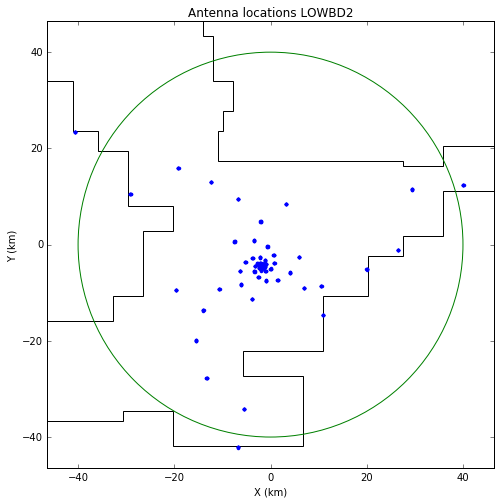

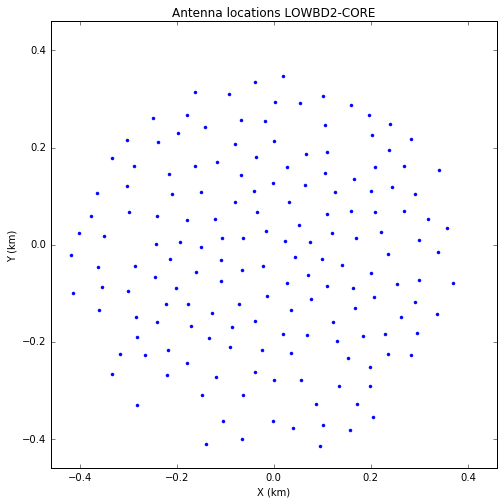

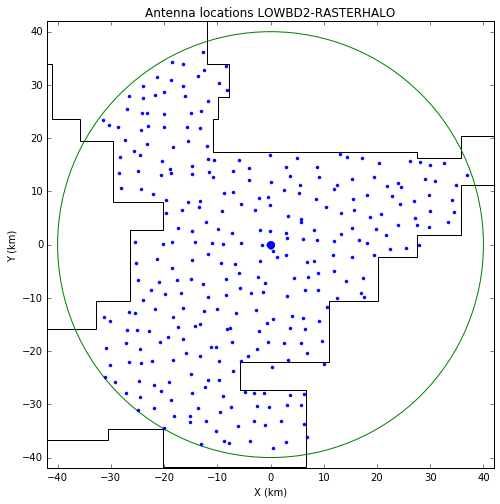

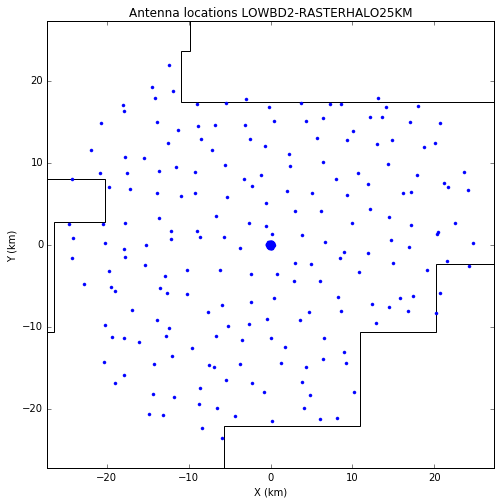

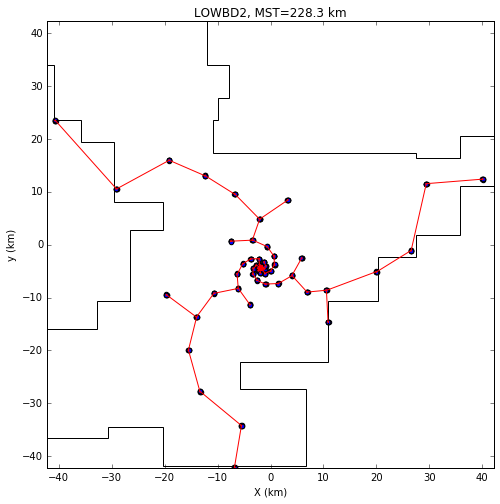

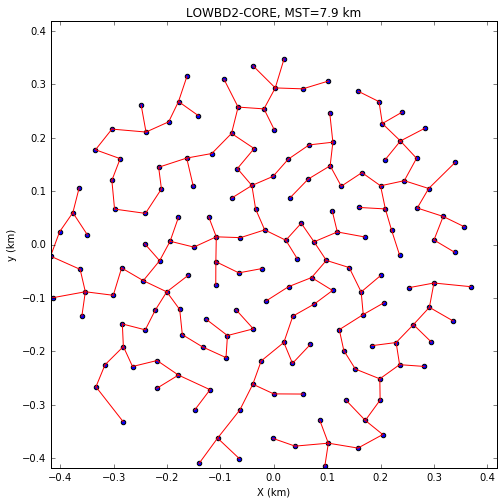

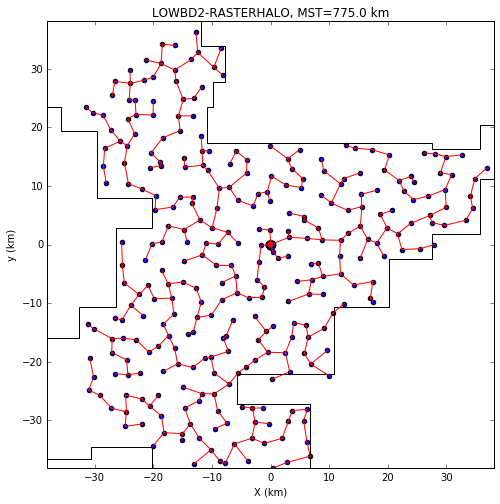

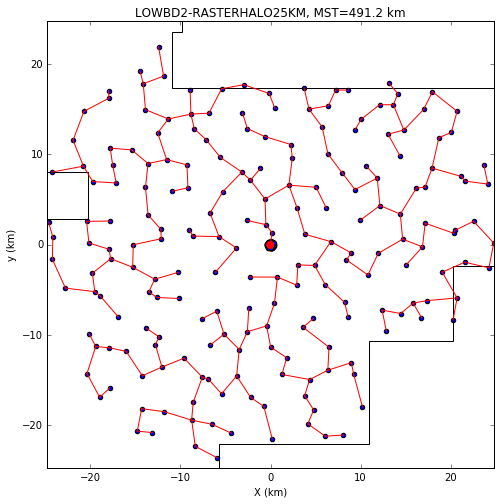

In [2]:

stats={}
tel={}
mst={}
configs = ['LOWBD2', 'LOWBD2-CORE', 'LOWBD2-RASTERHALO','LOWBD2-RASTERHALO25KM']

for config in configs:

# Define all config variants
    tel[config]=TelArray()
    if config=='LOWBD2':
        tel[config].readKML(kmlfile='V4Drsst512red_2.kml', weight=weight)
        tel[config].saveCSV('LOWBD2.csv')
    elif config =='LOWBD2-CORE':
        tel[config].readCSV('LOWBD2-CORE', l1def='LOWBD2-CORE.csv', recenter=True, weight=weight)
    elif config =='LOWBD2-HALO':
        tel[config].readCSV('LOWBD2-HALO', l1def='LOWBD2-HALO.csv', recenter=True, weight=weight)
    elif config == 'LOWBD2-RASTERHALO':
        tel['RASTERHALO']=TelArray()
        tel['RASTERHALO'].rasterBoolardy(nhalo=346, name='LOWRASTERHALO', nstations=346, scale=1.05, \
                           rhalo=40.0, rcore=0.0, weight=weight)
        tel[config]=TelArray().add(tel['RASTERHALO'],tel['LOWBD2-CORE'],name=config)
    elif config == 'LOWBD2-RASTERHALO25KM':
        tel['RASTERHALO25KM']=TelArray()
        tel['RASTERHALO25KM'].rasterBoolardy(nhalo=346, name='LOWRASTERHALO25KM', nstations=346, scale=40.0/rhalo, \
                           rhalo=rhalo, rcore=0.0, weight=weight)
        tel[config]=TelArray().add(tel['RASTERHALO25KM'],tel['LOWBD2-CORE'],name=config)
    elif config =='LOFAR':
        tel[config].readLOFAR(weight=weight)
# Plot and save the figure        
    tel[config].plot()
    plt.show()
    plt.savefig('%s.pdf'%config)

for config in configs:
    mst[config]=tel[config].mst()

### Now assess all configs for varying numbers of sources

Processing LOWBD2 5 sources
2016-05-29 16:25:08.079584
2016-05-29 16:25:08.079679
Source fluxes = [0.77130158629977053, 2.1011151059031454, 2.5586936559410756, 3.5792178061008078, 3.8331317738575188]


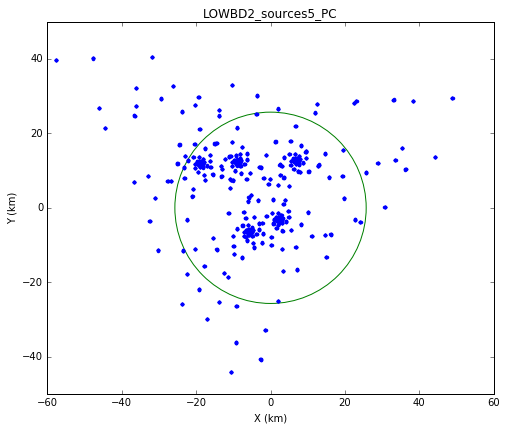

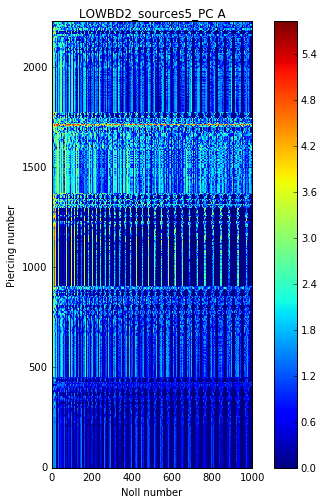

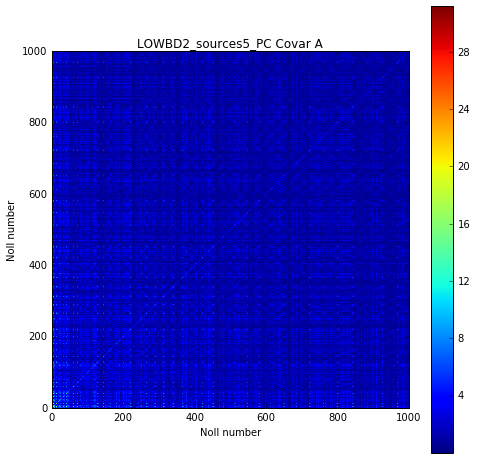

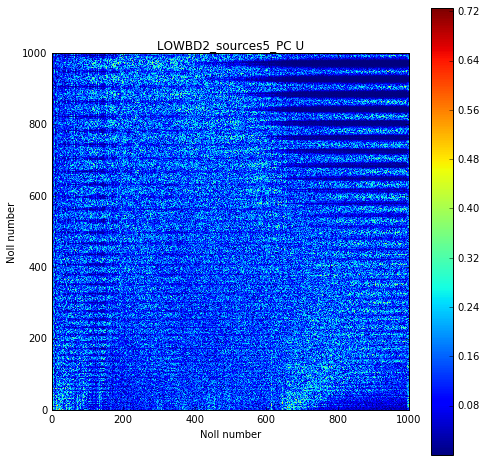

Trial 0, max(s)=61.7
Source fluxes = [0.87737533832955472, 0.94698316435477503, 1.5367860232096358, 4.4314834031796382, 5.1572873514784643]
Trial 1, max(s)=75.6
Source fluxes = [0.85757183537440818, 0.86793625997586432, 1.3249296706582929, 1.591394545007742, 2.1385316949942537]
Trial 2, max(s)=40.2
Source fluxes = [0.70391433616568322, 0.95089617473715382, 2.4385524952819955, 3.8440111450915331, 3.8687698971730797]
Trial 3, max(s)=57.6
Source fluxes = [0.87422130934778719, 1.1885708699800774, 1.2104561502414235, 3.2646818257397858, 5.9772791782715968]
Trial 4, max(s)=84.2
Source fluxes = [0.69658066514313222, 0.8159186661548804, 1.1206109406368616, 1.7141494426210786, 1.8685330430645286]
Trial 5, max(s)=27.3
Source fluxes = [0.86290007261466395, 1.0855103791942111, 1.3544423088241955, 1.5865619066111969, 2.0464262401231377]
Trial 6, max(s)=29.9
Source fluxes = [0.76096680816898998, 0.82720513776888283, 0.90687338144611895, 2.3731764349487574, 2.5382515234241176]
Trial 7, max(s)=40.7
So

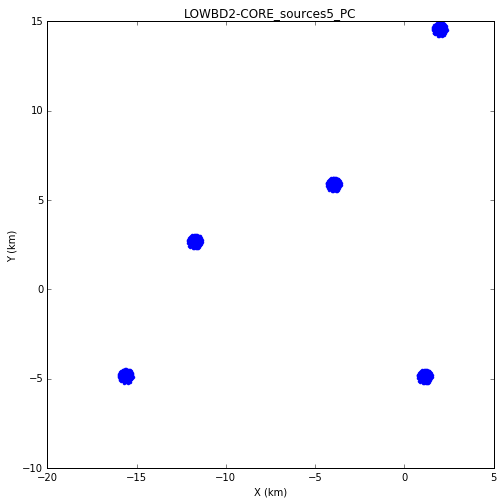

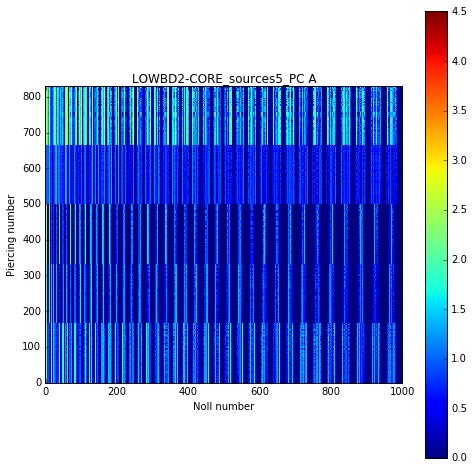

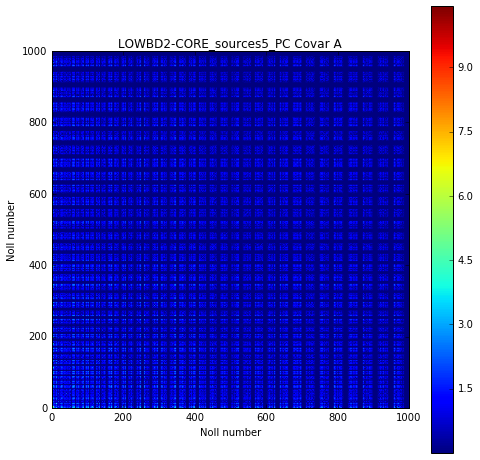

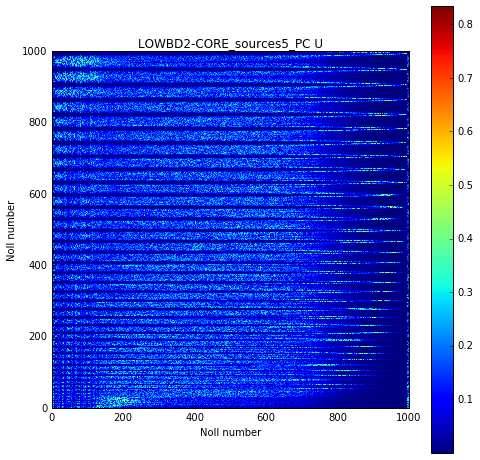

Trial 0, max(s)=30.9
Source fluxes = [0.79538469168743287, 1.1576699505008097, 1.4014065034859597, 2.1114304840336837, 3.2807073853042925]
Trial 1, max(s)=35.8
Source fluxes = [0.70512738872939229, 0.80266616672007418, 0.84774554571739524, 1.2229323931948681, 5.7626412794584603]
Trial 2, max(s)=77.7
Source fluxes = [0.95653657315462159, 1.4912139761774572, 3.9148061933376614, 4.8953421065304168, 5.9552977293165581]
Trial 3, max(s)=67.3
Source fluxes = [2.0380777035324984, 2.1531077776291858, 2.3956344783106482, 4.9245887636718315, 5.485830779022149]
Trial 4, max(s)=62.5
Source fluxes = [0.68053979607576076, 1.1600074522154771, 1.4407097555377766, 1.7251584059870058, 2.6783685233908656]
Trial 5, max(s)=32.7
Source fluxes = [1.0237872349251744, 1.2615636425416834, 1.4446511351892792, 2.0211380767674929, 5.3193999759630808]
Trial 6, max(s)=58.6
Source fluxes = [0.73967826307869866, 1.2923781697013412, 1.6728050645803849, 2.7811902599774654, 3.6678959611986719]
Trial 7, max(s)=41.6
Source 

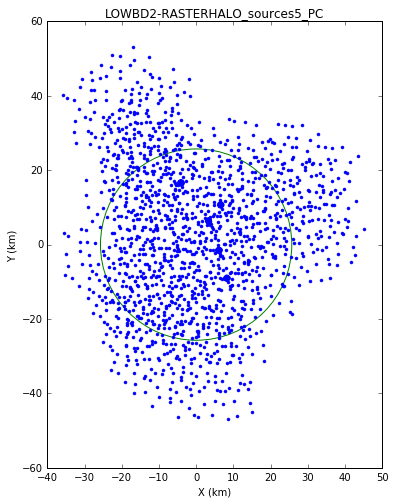

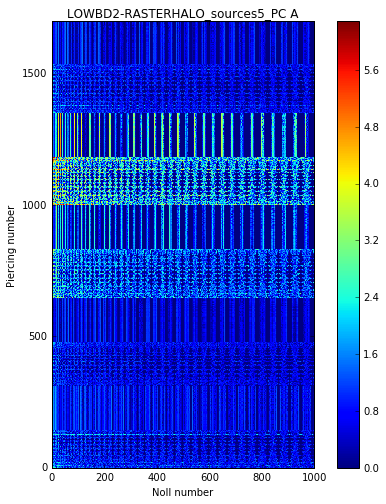

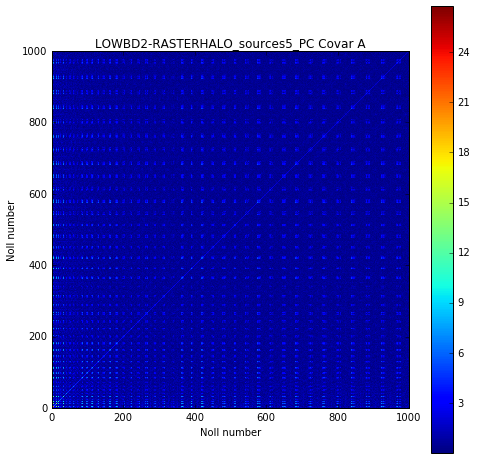

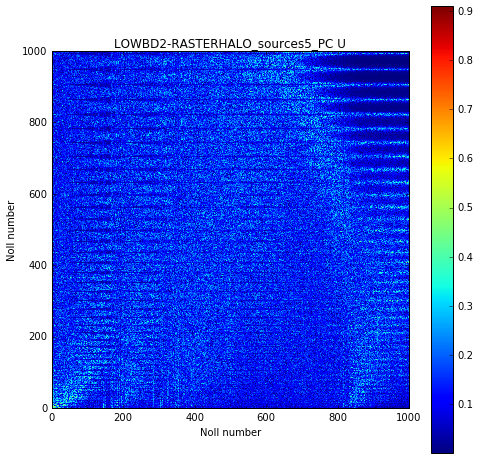

Trial 0, max(s)=58.5
Source fluxes = [1.2201083868763292, 1.237131530462513, 1.5120139997890092, 2.2800088643436256, 5.4761976922433799]
Trial 1, max(s)=63.2
Source fluxes = [0.70619001211993615, 0.79930425056708687, 0.84258319624841627, 1.0837789306292702, 4.7640232952916399]
Trial 2, max(s)=55.0
Source fluxes = [0.85292712363031165, 1.1635994647695465, 1.4836572847620606, 3.3012645112849115, 3.4889453455380797]
Trial 3, max(s)=43.4
Source fluxes = [0.73938099872575902, 0.81301956117312357, 1.1396696403887927, 1.2648857692322155, 3.889488922972542]
Trial 4, max(s)=43.8
Source fluxes = [0.88664640715191301, 1.3470042990095956, 2.6471902376752134, 3.9193561250650619, 5.1557950303600064]
Trial 5, max(s)=62.3
Source fluxes = [0.99251575172923689, 1.5238847078431357, 2.0665232747929601, 2.8362342091695747, 5.0529090080127723]
Trial 6, max(s)=57.8
Source fluxes = [0.89574461180279907, 1.3752295376076689, 1.7400531312663299, 1.7565297865948437, 4.2054575607134987]
Trial 7, max(s)=50.3
Source

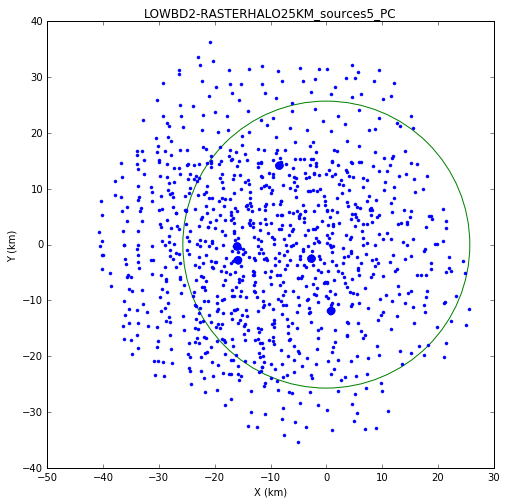

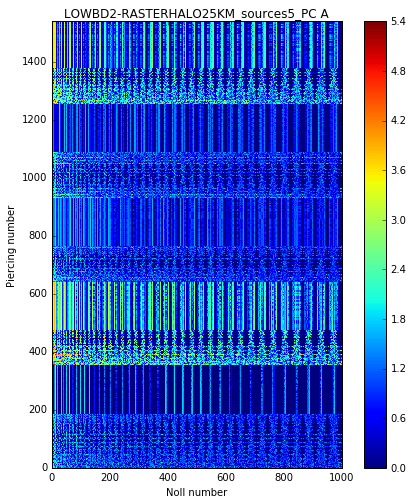

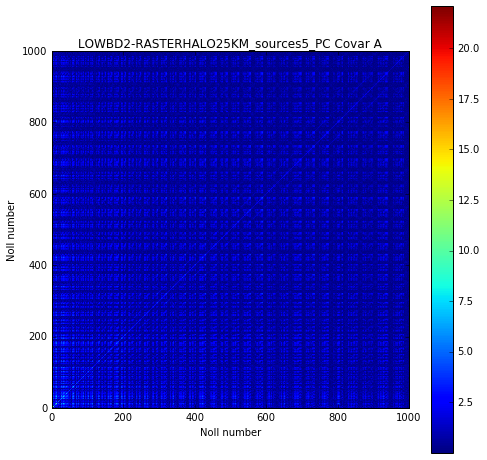

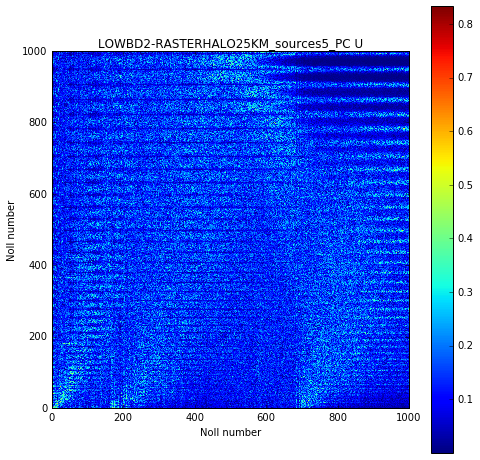

Trial 0, max(s)=48.8
Source fluxes = [0.74433904733200662, 1.1951181107207964, 1.3132246007634913, 2.0313307564877685, 3.0309295403316727]
Trial 1, max(s)=37.4
Source fluxes = [0.67381133904625623, 0.72005909483365271, 1.2138345384680638, 2.4943104459542478, 4.3249090461241932]
Trial 2, max(s)=47.8
Source fluxes = [1.0558787045123268, 1.4292011997523431, 1.6846853372183148, 2.2921984003764804, 3.9798782232843202]
Trial 3, max(s)=45.6
Source fluxes = [0.68370086116075357, 0.84250802322508533, 1.4595289648428755, 1.8811959141295178, 2.489796059226673]
Trial 4, max(s)=28.3
Source fluxes = [0.9476019622120242, 0.9969143761536664, 1.2363749190950584, 1.6252550071870289, 2.9871033211511473]
Trial 5, max(s)=33.7
Source fluxes = [0.72263183492258332, 0.8357425975321644, 0.95342033616621302, 1.0310172063132452, 2.1530555578630794]
Trial 6, max(s)=24.6
Source fluxes = [0.79735388457462553, 1.3517042577849974, 3.0509059710039619, 3.8203509611710196, 4.9029047950068367]
Trial 7, max(s)=56.7
Source

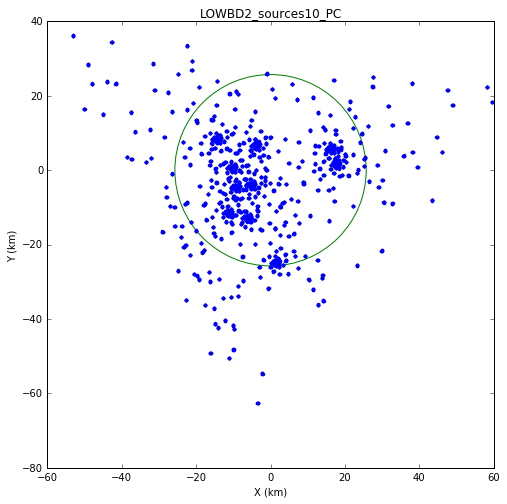

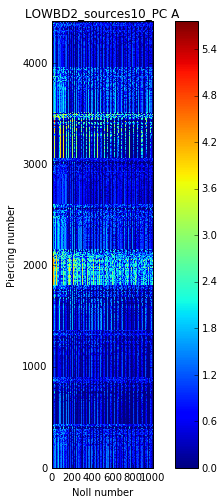

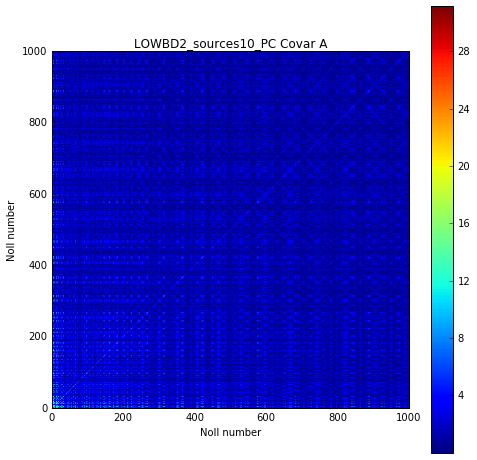

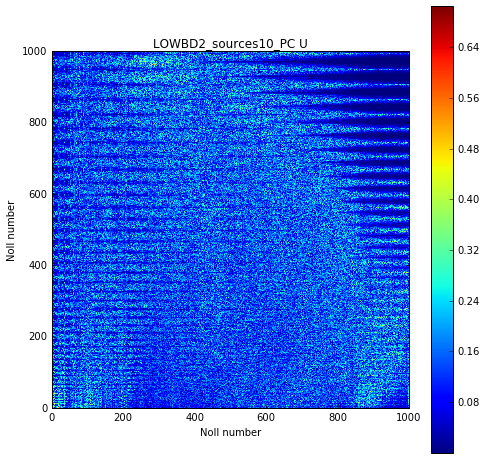

Trial 0, max(s)=63.2
Source fluxes = [0.72523501409655378, 0.73405925403358752, 0.80213423126313754, 0.84780497057530235, 1.1180396189680419, 1.1196645082341901, 1.3355795816765446, 2.9952052650970962, 4.1776889861695627, 6.0361855710734957]
Trial 1, max(s)=95.8
Source fluxes = [0.73341191755216073, 0.7718593688812464, 0.83386533777707161, 0.85972953607488689, 0.86861746272127938, 0.91292693364803268, 0.92163360512406933, 2.0811588863149333, 4.8828073492288748, 5.9708209284822429]
Trial 2, max(s)=86.6
Source fluxes = [0.70305230442565669, 0.78849715676839882, 0.82954482406543117, 0.84982641369274414, 0.89345788347542743, 0.95013395966060954, 1.1172887008204668, 2.166440939394902, 2.6037879651708846, 4.5639018657579413]
Trial 3, max(s)=63.8
Source fluxes = [0.818791109845462, 0.9301415420550021, 1.7896641194160496, 1.9195781841786224, 2.1230830290530722, 2.1298867860770114, 2.1321369588356118, 2.1609197776976492, 2.2515169396410872, 5.1736987502790193]
Trial 4, max(s)=72.6
Source fluxes

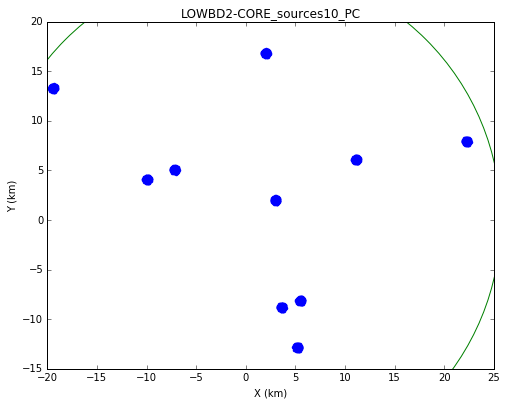

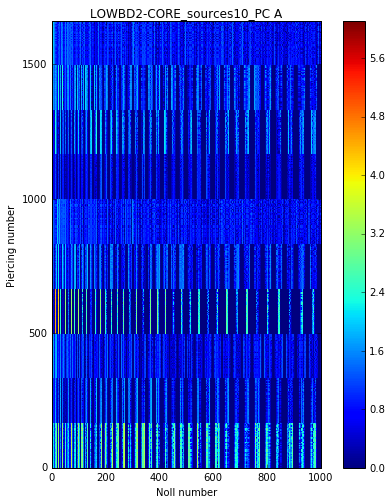

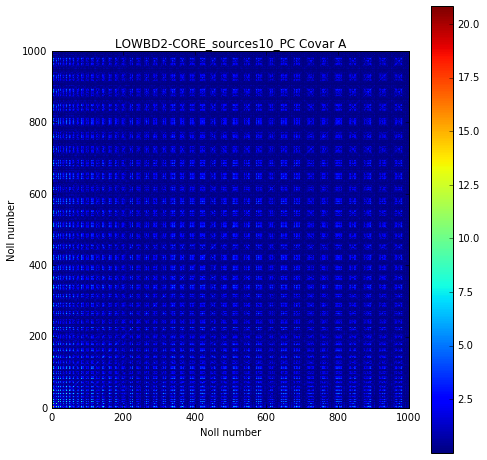

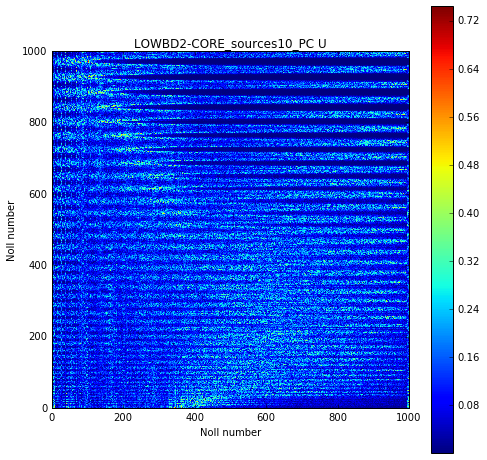

Trial 0, max(s)=54.7
Source fluxes = [0.75141719502628745, 0.7759482792706357, 0.81351850762834466, 1.6230129939042621, 2.2245279044976121, 2.7332065821025968, 3.3922228915888564, 3.6046861387262235, 4.3245717142030076, 4.6812013881493755]
Trial 1, max(s)=55.8
Source fluxes = [0.85842574107538827, 1.0425333767496852, 1.3050831972741062, 1.4029867902047715, 1.4216150519396937, 1.9838277781031672, 2.1811447406589468, 2.8049731881260427, 3.2240704632736468, 3.7541497750046533]
Trial 2, max(s)=44.3
Source fluxes = [0.6738660687594723, 0.67998983867609086, 0.75066761767949697, 0.78689588032146629, 0.94508914100825769, 1.1682620696611468, 1.2019142565083709, 1.7442745772724306, 2.4129353839287844, 4.9086525198899666]
Trial 3, max(s)=74.8
Source fluxes = [1.17886260749746, 1.2420946518988583, 1.2513938939934526, 1.4359700888273721, 1.5815255130325214, 1.6818643694392184, 1.9038077723148144, 2.1876569231725838, 3.2965784305129633, 4.2331095064953885]
Trial 4, max(s)=47.8
Source fluxes = [0.740

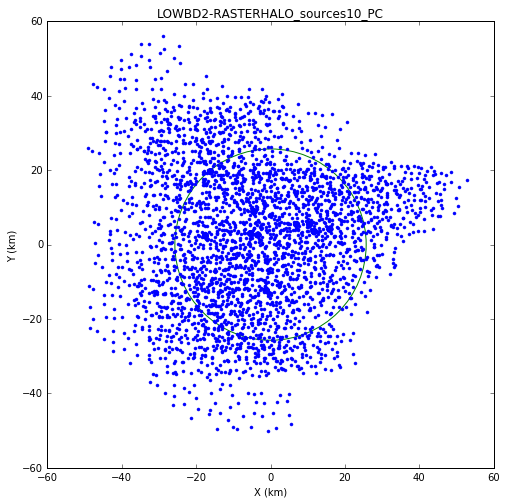

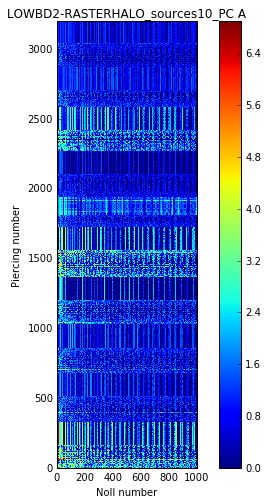

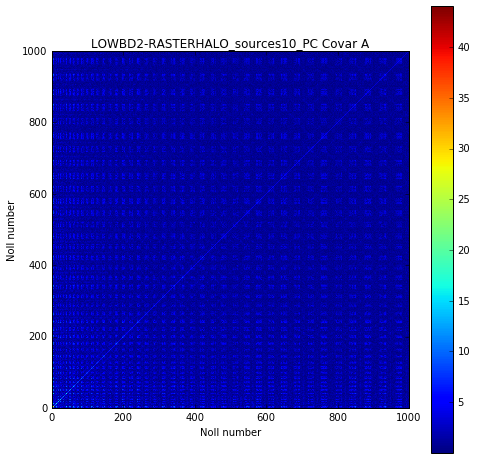

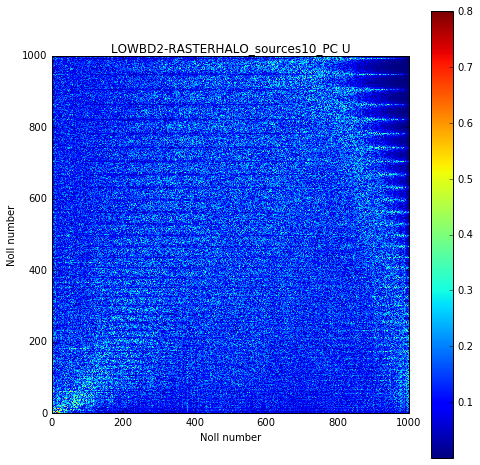

Trial 0, max(s)=72.8
Source fluxes = [0.68674428772401519, 0.71082126499210596, 0.7603999273380273, 0.77703050612230218, 1.0830403421058217, 1.1408297038734374, 1.1662790065826216, 1.1759723228076171, 1.5205754818665507, 2.3946206979072979]
Trial 1, max(s)=31.1
Source fluxes = [0.70357399502663442, 0.77527978626299165, 0.85708247756668454, 0.9090930072925193, 0.9204885989954138, 0.97378452246554115, 1.0725323399870541, 1.4449508964717424, 1.4913171997884458, 2.8359005308567955]
Trial 2, max(s)=32.7
Source fluxes = [0.70274754298883491, 1.0063411568076657, 1.1585470025240787, 1.1861156365429419, 1.2230435028936653, 1.2746764252148572, 1.3407962166061476, 1.9092550004097741, 3.2972207153719255, 4.5451602815709098]
Trial 3, max(s)=51.4
Source fluxes = [0.8960628158614985, 1.1606237189438917, 1.2063369934000023, 1.281701848591926, 1.3904846056410503, 1.4087855532534976, 1.5473814887969122, 1.6530134588904386, 2.381473480924384, 3.4442695519719968]
Trial 4, max(s)=42.9
Source fluxes = [0.67

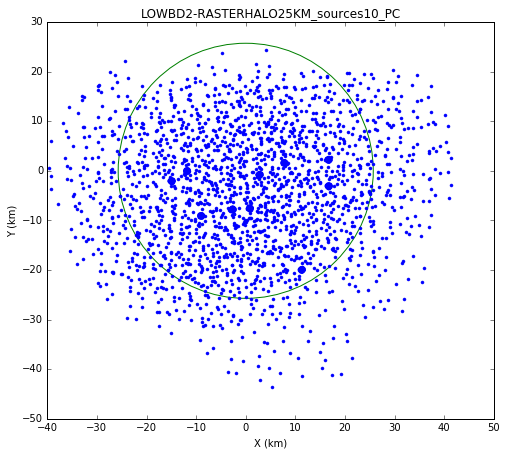

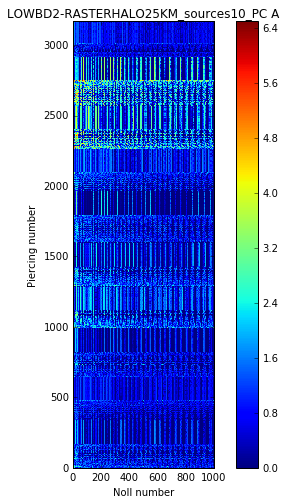

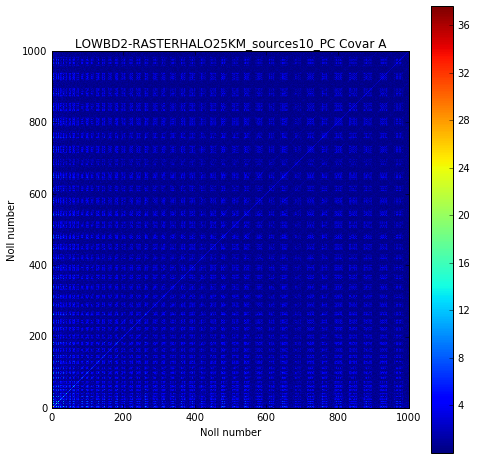

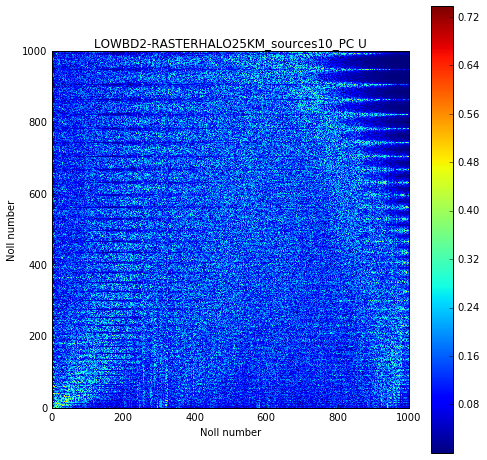

Trial 0, max(s)=64.2
Source fluxes = [0.67739684361945263, 0.78686523748577819, 0.85511092718044879, 1.0336528981832365, 1.1459153932553106, 1.2866277044215046, 2.3584440578007486, 3.9344933717429673, 4.9122842298824683, 6.5984147998340736]
Trial 1, max(s)=76.2
Source fluxes = [0.66948789829794531, 0.69410984316345103, 0.84513215078353698, 0.97379707571246998, 1.1497499050043938, 2.194509469840042, 3.7323444114911717, 3.837903225953585, 4.1925302809166087, 5.5960346154270981]
Trial 2, max(s)=70.7
Source fluxes = [0.7788447255425397, 0.84899413116828926, 1.1707699354987915, 1.2154982112056452, 1.2488434579213354, 1.309216405601987, 1.4500296038342002, 1.8575316903976922, 2.253234504836267, 2.6332453884646321]
Trial 3, max(s)=35.6
Source fluxes = [0.70669908996679376, 0.71136833133178956, 0.73103238719952568, 0.8024375899884183, 0.90883485198851177, 1.1112895065911113, 1.624719971603487, 2.7388966269965986, 3.4392839476324939, 5.7295012004743606]
Trial 4, max(s)=64.0
Source fluxes = [0.7

In [3]:
ntrials=10

lsources=[5, 10]

stats={}

for nsource in lsources:

    for config in configs:
        print "Processing %s %d sources" % (config, nsource)
        timestamp()
        if nsource==lsources[0]:
            stats[config]={}
        stats[config][nsource]=trials(ntrials, nsource, tel[config], config)      
        
timestamp()

### Now plot results for all the configs

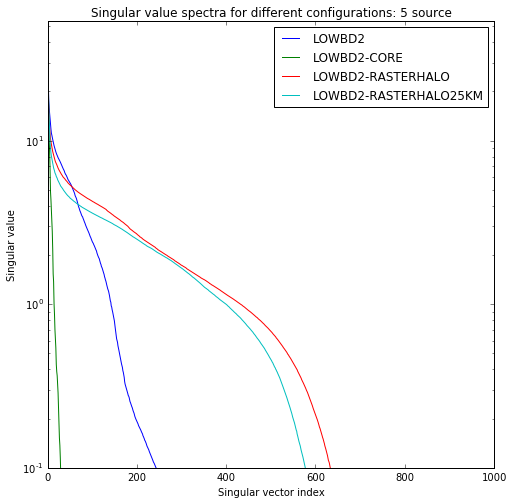

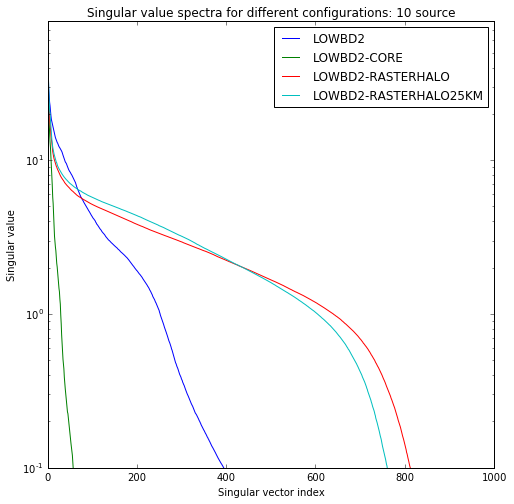

In [4]:
plt.clf()

for nsource in lsources:
    ymax=0.1
    for config in stats.keys():
        y=stats[config][nsource]['s']
        if numpy.max(y)>ymax:
            ymax=numpy.max(y)
        x=numpy.arange(nnoll)
        plt.semilogy(x, y, label=config)
    plt.legend(loc="upper right")
    plt.xlim([1,1000])
    plt.ylim([0.1,ymax])
    plt.xlabel('Singular vector index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectra for different configurations: %d source' % nsource)
    plt.show()

    plt.savefig('SingularValues_sources%d.pdf' % nsource)

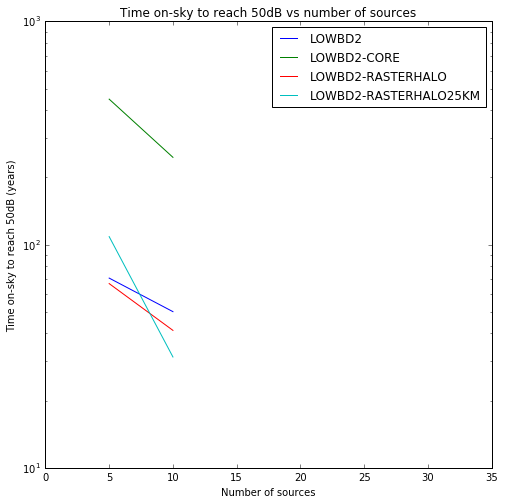

In [5]:
plt.clf()

for config in stats.keys():
    i=0
    x=numpy.zeros(len(lsources))
    y=numpy.zeros(len(lsources))
    for nsource in lsources:
        x[i]=nsource
        y[i]=stats[config][nsource]['tsky']/(365.0*24.0*3600.0)
        i=i+1
    plt.semilogy(x, y, label=config)
plt.legend(loc="upper right")
plt.xlabel('Number of sources')
plt.xlim([0,35])
plt.ylabel('Time on-sky to reach 50dB (years)')
plt.title('Time on-sky to reach 50dB vs number of sources')
plt.show()
plt.savefig('Timeonsky.pdf')
    

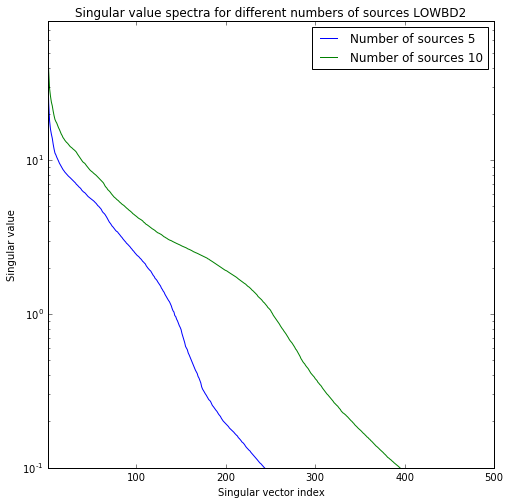

In [6]:
plt.clf()

config = 'LOWBD2'

for nsource in lsources:
    ymax=0.1
    y=stats[config][nsource]['s']
    if numpy.max(y)>ymax:
        ymax=numpy.max(y)
    x=numpy.arange(nnoll)
    plt.semilogy(x, y, label='Number of sources %d' %nsource)

plt.legend(loc="upper right")
plt.xlim([1,500])
plt.ylim([0.1,ymax])
plt.xlabel('Singular vector index')
plt.ylabel('Singular value')
plt.title('Singular value spectra for different numbers of sources %s' % (config))
plt.show()
plt.savefig('%s_Sources.pdf' % config)

In [7]:
printstats(stats)

Config, Nsources, peak, J, stdphase, DR, sky, MST
LOWBD2, 5, 50.4, 59, 0.11, 41.0, 70.8, 228.3
LOWBD2, 10, 79.8, 88, 0.09, 41.8, 50.1, 228.3
LOWBD2-CORE, 5, 53.6, 7, 0.27, 37.0, 448.4, 7.9
LOWBD2-CORE, 10, 57.9, 14, 0.20, 38.3, 246.0, 7.9
LOWBD2-RASTERHALO, 5, 50.8, 63, 0.10, 41.1, 66.9, 775.0
LOWBD2-RASTERHALO, 10, 53.7, 110, 0.08, 42.2, 41.3, 775.0
LOWBD2-RASTERHALO25KM, 5, 41.1, 36, 0.13, 40.1, 108.6, 491.2
LOWBD2-RASTERHALO25KM, 10, 65.1, 151, 0.07, 42.8, 31.4, 491.2
